In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from glob import glob
import os

In [2]:
import matplotlib
import seaborn as sns
sns.set(font_scale=1.1)
sns.set_style("whitegrid")
cmap = matplotlib.colormaps["tab10"]

In [3]:
# Read tabu grid search results
data = dict()

results_csvs = glob(os.path.join(os.pardir, "tabu_gs_results", "*.csv"))
for file_path in results_csvs:
    # Read csv
    df = pd.read_csv(file_path)
    file_name = file_path.split("/")[-1]
    instance_name = file_name.split("_")[0]
    if instance_name not in data.keys():
        data[instance_name] = dict()
    data[instance_name]["tabu_gs"] = df
data.keys()

dict_keys(['had20.dat', 'esc128.dat', 'els19.dat', 'nug30.dat', 'nug15.dat', 'bur26c.dat', 'wil100.dat', 'tai60a.dat'])

In [4]:
# Read solutions
data_path = os.path.join(os.pardir, "data", "qapdatsol")
for instance in data.keys():
    solution_file = instance[:-3] + "sln"
    print(solution_file)
    full_path = os.path.join(data_path, solution_file)

    f = open(full_path, "r")
    first_line = f.readline().strip().split(" ")
    # The first line contains the instance size
    # And the evaluation of the OPT
    n, opt = int(first_line[0]), float(first_line[-1])
    data[instance]["n"] = n
    data[instance]["opt"] = opt
    opt_sol = []
    while True:
        line = f.readline()
        if not line:
            break
        elements = [ele for ele in line.strip().split(" ") if len(ele) > 0]
        # Additional comma split if necessary
        if len(elements) == 1:
            elements = elements[0].split(",")
        elements = list(map(int, elements))
        opt_sol.extend(elements)
    data[instance]["opt_sol"] = opt_sol
    # Calculate qualities for tabu
    data[instance]["tabu_gs"]["quality"] = (data[instance]["tabu_gs"]["eval_mean"]-data[instance]["opt"])/data[instance]["opt"]
    f.close()

had20.sln
esc128.sln
els19.sln
nug30.sln
nug15.sln
bur26c.sln
wil100.sln
tai60a.sln


In [5]:
# Read greedy and steepest results
results_csvs = glob(os.path.join(os.pardir, "results", "*_steepest.csv")) + glob(os.path.join(os.pardir, "results", "*_greedy.csv"))
for file_path in results_csvs:
    # Read csv
    df = pd.read_csv(file_path)
    file_name = file_path.split("/")[-1]
    instance_name = file_name.split("_")[0]
    # Drop the cvs extension
    method_name = "_".join(file_name.split("_")[1:])[:-4]
    if instance_name not in data.keys():
        data[instance_name] = dict()
    data[instance_name][method_name] = pd.DataFrame([[df["final_evaluation"].mean(),
                                                    df["final_evaluation"].std(),
                                                    df["time"].mean(), df["time"].std(),
                                                    (df["final_evaluation"].mean()-data[instance_name]["opt"])/data[instance_name]["opt"]]],
                                                    columns=["eval_mean", "eval_std", "time_mean", "time_std", "quality"])

In [6]:
print(data["had20.dat"]["greedy"])

   eval_mean   eval_std  time_mean  time_std   quality
0     7004.4  72.072803        6.5  1.354006  0.011904


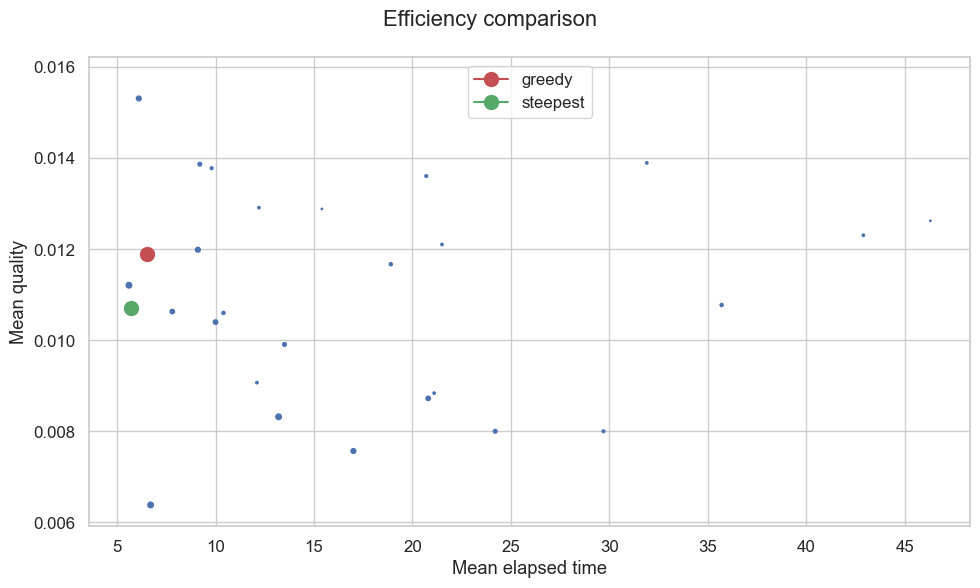

In [7]:
fig, ax = plt.subplots(figsize = (10,6))

instance = "had20.dat"

tabu_df = data[instance]["tabu_gs"]
#ls_df = data[instance]["local_search"]
ax.scatter(tabu_df["time_mean"], tabu_df["quality"], tabu_df["k"])
ax.plot(data[instance]["greedy"]["time_mean"], data[instance]["greedy"]["quality"],
        marker='o', markersize=10, color='r', linestyle=None, label="greedy")
ax.plot(data[instance]["steepest"]["time_mean"], data[instance]["steepest"]["quality"],
        marker='o', markersize=10, color='g', linestyle=None, label="steepest")
ax.set_xlabel("Mean elapsed time")
ax.set_ylabel("Mean quality")

fig.suptitle("Efficiency comparison")
fig.tight_layout()
plt.legend()
plt.legend(loc = "upper center")

In [8]:
import plotly.express as px

In [9]:
for instance in data.keys():

    tabu_df = data[instance]["tabu_gs"]
    #ls_df = data[instance]["local_search"]
    fig = px.scatter(data[instance]["tabu_gs"], x = "time_mean", y= "quality",
            title=f"Efficiency plot for {instance}",
            labels={ # replaces default labels by column name
                    "time_mean": "Mean time",  "quality": "Mean quality",
                    "lack_impr_iter": "Iterations without improvement"
                },
            color='eval_std',
            hover_data=['tenure', 'k', 'lack_impr_iter'])
    fig.add_scatter(x=data[instance]["greedy"]["time_mean"],
                    y=data[instance]["greedy"]["quality"],
                    marker=dict(color='green',size=10),
                name='greedy')
    fig.add_scatter(x=data[instance]["steepest"]["time_mean"],
                    y=data[instance]["steepest"]["quality"],
                    marker=dict(color='red',size=10),
                name='steepest')
    fig.update_layout(legend=dict( 
        orientation="h", 
    
    )) 
    fig.show()


### Print a table with parameter values

In [11]:
import pandas as pd
import os
config = pd.read_json(os.path.join(os.pardir, "configs", "tabu.json"), orient="columns")
#config.columns = [column[:-4] for column in config.columns]
config

,nug15.dat,nug30.dat,els19.dat,esc128.dat,had20.dat,tai60a.dat,wil100.dat,bur26c.dat
tenure,6,9,1,12,4,12,20,10
k,9,13,2,18,6,24,20,20
lack_impr_iter,50,50,300,50,50,50,150,100
